In [2]:
pip install chembl_webresource_client

     |████████████████████████████████| 61kB 1.7MB/s 
  Created wheel for chembl-webresource-client: filename=chembl_webresource_client-0.10.2-cp36-none-any.whl size=55661 sha256=4cdffe21d016ab88e8ddf671a99c2834fc3a09e0d010f657e86cead3cbec9c56
  Stored in directory: /root/.cache/pip/wheels/e6/96/19/3f042bfda7c669bfe24c8278477f57b0fbbf3e488b4c09e3a8
Successfully built chembl-webresource-client


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test_precision_weighted: 0.4480 (+/- 0.1051)
test_recall_weighted: 0.3262 (+/- 0.1488)
test_f1_weighted: 0.3411 (+/- 0.1250)
test_accuracy: 0.3262 (+/- 0.1488)
MCC: 0.1250 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

precision_weighted100: 0.4557 (+/- 0.0150)
recall_weighted100: 0.3384 (+/- 0.0208)
f1_weighted100: 0.3475 (+/- 0.0161)
accuracy100: 0.3384 (+/- 0.0208)
mcc100: 0.1051 (+/- 0.0102)
                      precision    recall  f1-score   support

              Enzyme       0.61      0.35      0.44      1726
   Membrane receptor       0.27      0.51      0.35       354
Transcription factor       0.03      0.23      0.06        81
         Ion channel       0.22      0.53      0.31       206
               Other       0.33      0.21      0.25      1048

            accuracy                           0.33      3415
           macro avg       0.29      0.37      0.28      3415
        weighted avg       0.45      0.33      0.36      3415



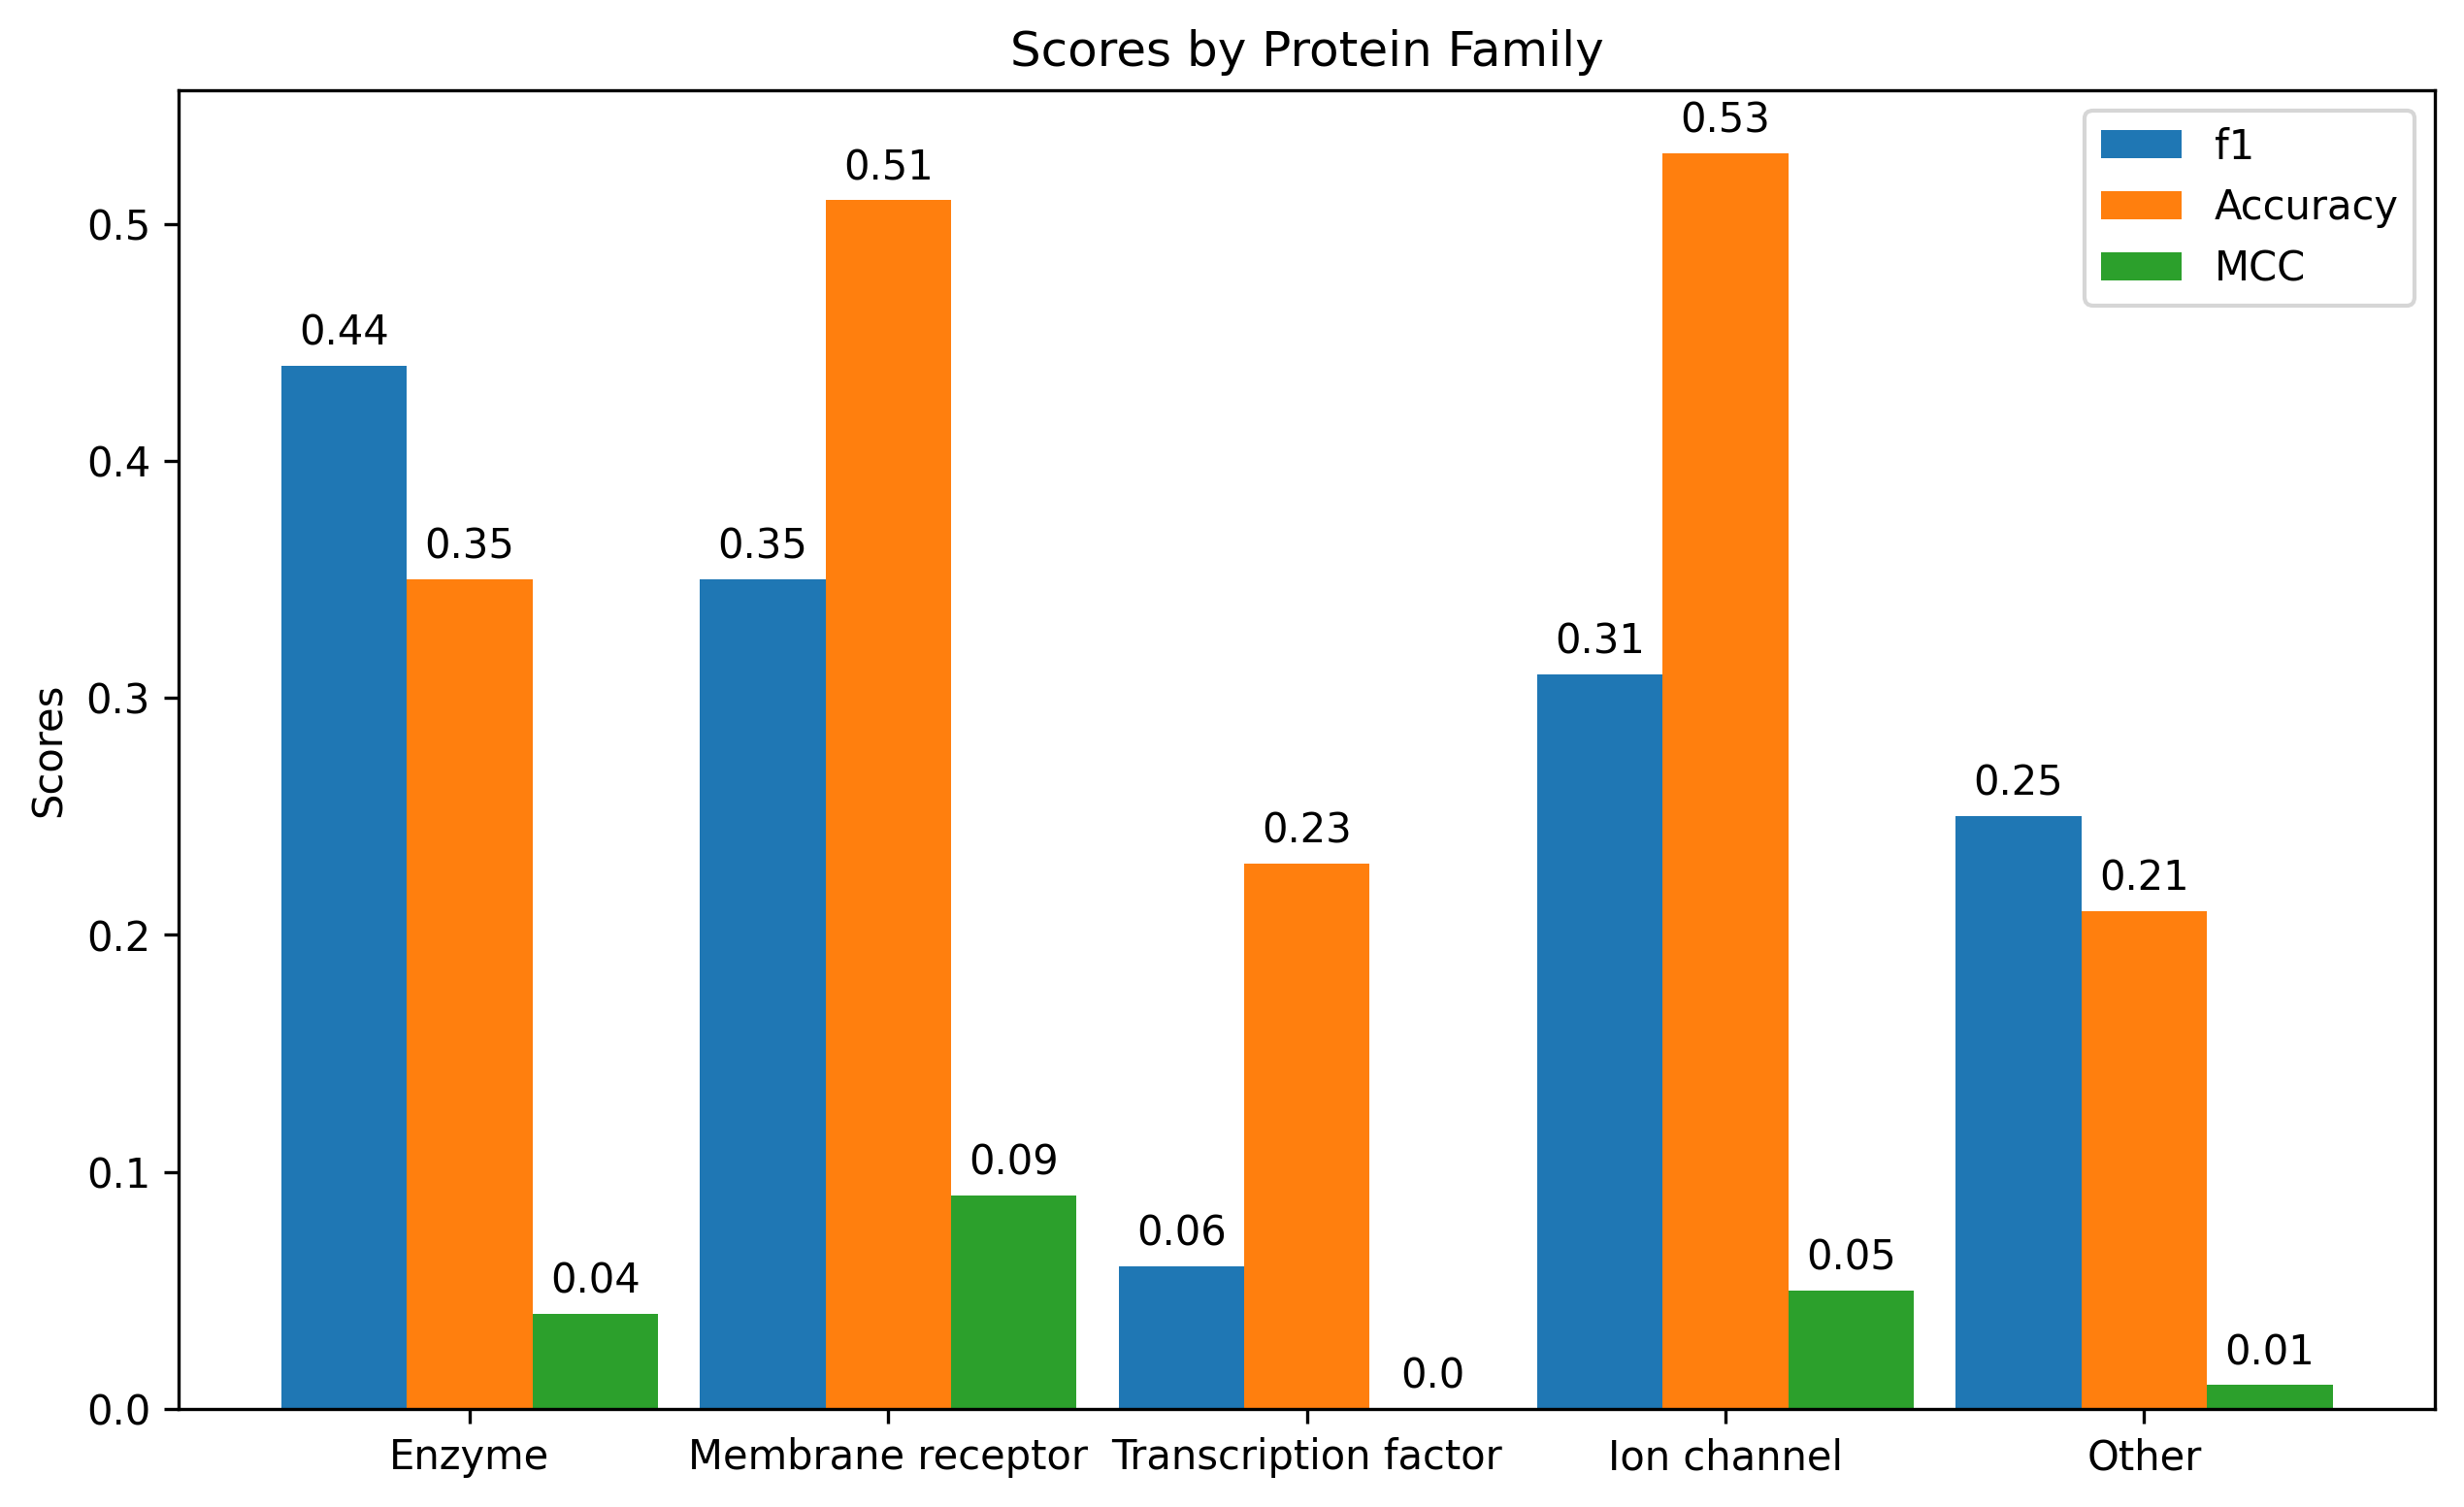

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun  8 09:32:26 2020

@author: Muammer
"""

from chembl_webresource_client.new_client import new_client
import urllib.parse
import urllib.request
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd 

uniprot2chembl = ''
vecsize = 0

dataframe = pd.read_pickle("/content/drive/My Drive/multiclass_data/tcga_embedding_dataframe.pkl")

vec = dataframe['Vector'][0][1:]
vec = vec[:-1]
vec = np.array(vec.split(", "))
vecsize = len(vec)


for index, row in dataframe.iterrows():
    uniprot2chembl = uniprot2chembl + ' ' + row['Entry']       
        
x = np.empty([0, vecsize])
y = []
       
url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'ACC+ID',
'to': 'CHEMBL_ID',
'format': 'list',
'query': uniprot2chembl
}

chembl_id = ''

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   chembl_id = f.read().decode('utf-8')

chembl_ids = list(chembl_id.split('\n'))

for i in range(len(chembl_ids)):

    try:
        target = new_client.target
        target.set_format('json')
        record_via_client = target.get(chembl_ids[i])
    
        tcomp = new_client.target_component
        tcomp.set_format('json')
        pcid = tcomp.filter(component_id__exact=record_via_client['target_components'][0]['component_id'])
        
        pdrow = dataframe.loc[dataframe['Entry'] == record_via_client['target_components'][0]['accession']]
        if len(pdrow.index) > 0:
            a = pdrow.iloc[0]['Vector'][1:]
            a = a[:-1]
            a = np.array(a.split(", "))
            a.shape = (1,vecsize)
            x = np.append(x, a, axis=0)
        
            pclass = new_client.protein_class
            pclass.set_format('json')
            pc = pclass.filter(protein_class_id__exact=pcid[0]['protein_classifications'][0]['protein_classification_id'])
        
            if pc[0]['l1'] == 'Enzyme':
                y.append(1)
            elif pc[0]['l1'] == 'Ion channel':
                y.append(1005)
            elif pc[0]['l1'] == 'Membrane receptor':
                y.append(11)
            elif pc[0]['l1'] == 'Transcription factor':
                y.append(12)
            else:
                y.append(2000)  
    except :
            pass

    
x = x.astype(np.float64)
y = np.array(y)
y = y.astype(np.float64)

clf = linear_model.SGDClassifier(class_weight="balanced", loss="log", penalty="elasticnet", max_iter=1000, tol=1e-3)
clf1 = OneVsRestClassifier(clf)

scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted', 'accuracy']

cv_results = cross_validate(clf1, x, y, cv=10, scoring = scoring)

print("test_precision_weighted: %0.4f (+/- %0.4f)" % (cv_results.get('test_precision_weighted').mean(), cv_results.get('test_precision_weighted').std() * 2))
print("test_recall_weighted: %0.4f (+/- %0.4f)" % (cv_results.get('test_recall_weighted').mean(), cv_results.get('test_recall_weighted').std() * 2))
print("test_f1_weighted: %0.4f (+/- %0.4f)" % (cv_results.get('test_f1_weighted').mean(), cv_results.get('test_f1_weighted').std() * 2))
print("test_accuracy: %0.4f (+/- %0.4f)" % (cv_results.get('test_accuracy').mean(), cv_results.get('test_accuracy').std() * 2))

y_pred = cross_val_predict(clf1, x, y, cv=10)
mcc = matthews_corrcoef(y, y_pred, sample_weight = y)
print("MCC: %0.4f " % (mcc))

target_names = ['Enzyme', 'Membrane receptor', 'Transcription factor', 'Ion channel', 'Other']

result = classification_report(y, y_pred, target_names=target_names)

labels = [1.0, 11.0, 12.0, 1005.0, 2000.0]
f1 = f1_score(y, y_pred, labels=labels, average=None)
f1 = f1.round(decimals=2)

cm = confusion_matrix(y, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracy = cm.diagonal()
accuracy = accuracy.round(decimals=2)

mcc = []

y1 = np.empty([0])
y11 = np.empty([0])
y12 = np.empty([0])
y1005 = np.empty([0])
y2000 = np.empty([0])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)

testsize = np.size(X_test,0)

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

for i in range(testsize):
    if y_test[i] == 1:
        y1 = np.append(y1 ,y_test[i])
    else:
        y1 = np.append(y1 ,0)
    if y_test[i] == 11:
        y11 = np.append(y11 ,y_test[i])
    else:
        y11 = np.append(y11 ,0)
    if y_test[i] == 12:
        y12 = np.append(y12 ,y_test[i])
    else:
        y12 = np.append(y12 ,0)
    if y_test[i] == 1005:
        y1005 = np.append(y1005 ,y_test[i])
    else:
        y1005 = np.append(y1005 ,0)
    if y_test[i] == 2000:
        y2000 = np.append(y2000 ,y_test[i])
    else:
         y2000 = np.append(y2000 ,0)

clf2 = OneVsRestClassifier(clf).fit(X_train, y_train)
pred_data = clf2.predict(X_test)

mcc.append(matthews_corrcoef(y1, pred_data))
mcc.append(matthews_corrcoef(y11, pred_data))
mcc.append(matthews_corrcoef(y12, pred_data))
mcc.append(matthews_corrcoef(y1005, pred_data))
mcc.append(matthews_corrcoef(y2000, pred_data))

mcc = np.array(mcc)

mcc = mcc.round(decimals=2)


precision_weighted100 = []
recall_weighted100 = []
f1_weighted100 = []
accuracy100 = []
mcc100 = []

for i in range(100):
    cv_results = cross_validate(clf1, x, y, cv=10, scoring = scoring)
    
    y_pred = cross_val_predict(clf1, x, y, cv=10)
    mcc100.append(matthews_corrcoef(y, y_pred, sample_weight = y))

    precision_weighted100.append(cv_results.get('test_precision_weighted').mean())
    recall_weighted100.append(cv_results.get('test_recall_weighted').mean())
    f1_weighted100.append(cv_results.get('test_f1_weighted').mean())
    accuracy100.append(cv_results.get('test_accuracy').mean())

precision_weighted100 = np.array(precision_weighted100)
recall_weighted100 = np.array(recall_weighted100)
f1_weighted100 = np.array(f1_weighted100)
accuracy100 = np.array(accuracy100)
mcc100 = np.array(mcc100)

print("precision_weighted100: %0.4f (+/- %0.4f)" % (precision_weighted100.mean(), np.std(precision_weighted100)))
print("recall_weighted100: %0.4f (+/- %0.4f)" % (recall_weighted100.mean(), np.std(recall_weighted100)))
print("f1_weighted100: %0.4f (+/- %0.4f)" % (f1_weighted100.mean(), np.std(f1_weighted100)))
print("accuracy100: %0.4f (+/- %0.4f)" % (accuracy100.mean(), np.std(accuracy100)))
print("mcc100: %0.4f (+/- %0.4f)" % (mcc100.mean(), np.std(mcc100)))

print(result)

xb = np.arange(len(target_names))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(dpi = 300, figsize=(10,6))

rects1 = ax.bar(xb - width, f1, width, label='f1')
rects2 = ax.bar(xb, accuracy, width, label='Accuracy')
rects3 = ax.bar(xb + width, mcc, width, label='MCC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Protein Family')
ax.set_xticks(xb)
ax.set_xticklabels(target_names)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)